# Generate a random symmetric or euclidean graph

In [9]:
from random import randint, choice, shuffle, random
from pprint import pprint
from itertools import permutations
from math import inf as oo # Infinity (∞) is larger than any number
from math import sqrt
from time      import time
import matplotlib.pyplot as plt
import copy
import numpy as np

MAX_DISTANCE = 100

def random_symmetric_graph(n):
    ''' Symmetric adjacency matrix of size nxn '''
    dist_matrix = [[oo for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(i+1,n):
            v = randint(1,MAX_DISTANCE)
            dist_matrix[i][j] = v
            dist_matrix[j][i] = v
    return dist_matrix

def random_euclidean_graph(n):
    ''' Symmetric adjacency matrix of a Euclidean graph of size nxn '''
    dist_matrix = [[oo for _ in range(n)] for _ in range(n)]
    points = []
    for p in range(n):
        x,y = randint(0,MAX_DISTANCE), randint(0,MAX_DISTANCE)
        points.append((x,y))
    for i in range(n):
        p1 = points[i]
        for j in range(i+1,n):
            p2 = points[j]
            distance = sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)
            dist_matrix[i][j] = distance
            dist_matrix[j][i] = distance
    return dist_matrix

def show(G):
    ''' Show adjacency matrix. Useful for debugging. '''
    n = len(G)
    r = "     "
    for i in range(n):
        r += f'{i:4}'
    r += '\n    -'+'-'*(4*n)+'\n'
    for i in range(n):
        r += f'{i:2} | '
        for j in range(n):
            r += f'{G[i][j]:4}'
        r += '\n'
    r = r.replace('inf', '  ∞')
    print(r)

def cost(G, cycle):
    ''' Calculate the cost of the given cycle '''
    c = 0
    n = len(G)
    for i in range(n):
        a = cycle[i]
        b = cycle[(i+1)%n]
        c += G[a][b]
    return c

J = random_euclidean_graph(5)
G = random_symmetric_graph(5)
show(J)
show(G)

# Create a first generation of x(population) random possible routes

With a given graph, randomly generate a 'population' of possible routes

Pseudocode



In [10]:
G = random_symmetric_graph(5)
population = 6
show(G)

'''Used the shuffle function to generate a 'population' sized amount'''
'''of possible routes'''

def createGen(matrix, population):
    route = []
    genZ = [None] * int(population)
    for i in range(0,len(matrix)):
        route.append(i)
    for j in range(0,int(population)):
        if j == 0:
            np.random.shuffle(route)
            newRoute = route[:]
            genZ[j] = newRoute
        else:
            np.random.shuffle(route)
            for h in range(0,len(genZ)):
                if route == genZ[h]:
                    np.random.shuffle(route)
            newRoute = route[:]
            genZ[j] = newRoute
    return genZ

print("Genenration 0")        
print(createGen(G,6))

[[inf, 47, 56, 62, 87], [47, inf, 5, 100, 68], [56, 5, inf, 17, 9], [62, 100, 17, inf, 70], [87, 68, 9, 70, inf]]
        0   1   2   3   4
    ---------------------
 0 |    ∞  47  56  62  87
 1 |   47   ∞   5 100  68
 2 |   56   5   ∞  17   9
 3 |   62 100  17   ∞  70
 4 |   87  68   9  70   ∞

Genenration 0
[[4, 0, 3, 1, 2], [3, 4, 1, 2, 0], [0, 4, 1, 2, 3], [3, 4, 1, 0, 2], [0, 2, 3, 1, 4], [3, 1, 0, 4, 2]]


# Rank the "fitness" of these routes aka length

We use the values in the graph to create a new list of positiv integer which represents, for each route, the sum of all its edges cost for a loop (TSP), the travelling distance.

Pseudocode

In [11]:
def fitness(matrix, routes):
    fitnessRanking = []
    for i in range(0, len(routes)):
        fitnessTotal = 0
        for j in range(0,len(matrix)):
            if j + 1 < len(matrix):
                fitnessTotal = fitnessTotal + int(matrix[routes[i][j]][routes[i][j+1]])
            else:
                fitnessTotal = fitnessTotal + int(matrix[routes[i][j]][routes[i][0]])
        fitnessRanking.append(fitnessTotal)
    return fitnessRanking

show(G)
print("Genenration 0")        
genZ = createGen(G,6)
print(genZ)
print("Fitness")
ranking = fitness(G, genZ)
print(ranking)

        0   1   2   3   4
    ---------------------
 0 |    ∞  47  56  62  87
 1 |   47   ∞   5 100  68
 2 |   56   5   ∞  17   9
 3 |   62 100  17   ∞  70
 4 |   87  68   9  70   ∞

Genenration 0
[[0, 1, 4, 2, 3], [1, 2, 0, 3, 4], [1, 3, 4, 0, 2], [4, 3, 2, 1, 0], [1, 4, 0, 2, 3], [1, 0, 3, 2, 4]]
Fitness
[203, 261, 318, 226, 328, 203]


# Choose the parents for mating with Elitism

We then find the two routes with the lowest traveling distance by copying and sorting the rank list into a new list to find the top two.
Then we find the position of them in the ranking list and in so in the routes list

Pseudocode


In [12]:
def first(ranking, routes):
    sortedRank = ranking[:]
    sortedRank.sort()
    firstPos = ranking.index(sortedRank[0])
    firstRoute = routes[firstPos]
    return firstRoute

def second(ranking, routes):
    sortedRank = ranking[:]
    sortedRank.sort()
    secondPos = ranking.index(sortedRank[1])
    secondRoute = routes[secondPos]
    return secondRoute
    
win = first(ranking, genZ)
print(win)
win2 = second(ranking, genZ)
print(win2)
    

[0, 1, 4, 2, 3]
[0, 1, 4, 2, 3]


# Breeding

We then breed the those two routes together to create a new generation of routes.
To do so we take a random segment of random lentgh of the first parent and then put into the child (same segment in same position).
Then we fill in from next index in the child with the second parents nodes.

Pseudocode

In [13]:
def breed(parent1, parent2, population):
    nextGen = []
    
    for i in range(0,population):
        child = []
        childP1 = []
        childP2 = []
    
    
        geneA = int(np.random.random() * len(parent1))
        geneB = int(np.random.random() * len(parent1))
    
        startGene = min(geneA, geneB)
        endGene = max(geneA, geneB)
    
        for i in range(startGene, endGene):
            childP1.append(parent1[i])
        
        childP2 = [item for item in parent2 if item not in childP1]
        child = childP1 + childP2
        nextGen.append(child)
    
    return nextGen
    
nextGen = breed(win, win2, population)
print(nextGen)

[[1, 0, 4, 2, 3], [1, 0, 4, 2, 3], [0, 1, 4, 2, 3], [0, 1, 4, 2, 3], [1, 0, 4, 2, 3], [1, 4, 2, 0, 3]]


# Mutation

We also randomly mutate each child route with a decided rate.
We apply it to a whole gen to make it easier.

In [16]:
'''Mutation rate set to 5%'''

mutation = 0.05

def mutate(child, mutationRate):
    for swapped in range(len(child)):
        if(np.random.random() <= mutationRate):
            swapWith = int(np.random.random() * len(child))
            
            node1 = child[swapped]
            node2 = child[swapWith]
            
            child[swapped] = node2
            child[swapWith] = node1
    return child

def mutateGen(currentGen, mutationRate, population):
    mutatedGen = []
    
    for child in range(0, population):
        mutatedChild = mutate(currentGen[child], mutationRate)
        mutatedGen.append(mutatedChild)
        
    return mutatedGen

mutatedGen = mutateGen(nextGen,mutation, population)
print(mutatedGen)

[[1, 0, 4, 2, 3], [1, 0, 4, 2, 3], [0, 1, 4, 2, 3], [0, 1, 4, 2, 3], [1, 0, 4, 2, 3], [1, 4, 2, 0, 3]]


# Repeat

A function to repeat this whole cycle of ranking, breeding and mutating to create a new generation

Pseudocode


In [17]:

def nextGeneration(mutatedGen, population, mutationRate):
    rank = fitness(G, mutatedGen)
    parent1 = first(rank, mutatedGen)
    parent2 = second(rank, mutatedGen)
    currentGen = breed(parent1, parent2, population)
    nextGeneration = mutateGen(currentGen, mutationRate, population)
    return nextGeneration

print(nextGeneration(mutatedGen, population, mutation))

[[2, 0, 1, 4, 3], [4, 2, 0, 1, 3], [1, 0, 4, 2, 3], [0, 3, 4, 2, 1], [0, 1, 4, 2, 3], [1, 0, 4, 2, 3]]


# Evolution

Allows us to see the evolution of the routes after x generations, starting by showing us the first best route with its value and finishing by showing us the new best one.

Pseudocode


In [119]:
def geneticAlgorithm(population, matrix, mutationRate, generations):
    result = []
    gen = createGen(matrix, population)
    rank = fitness(G, gen)
    rank.sort()
    print("Initial best route: ")
    print(rank[0])
    initBestRouteVal = rank[0]
    bestRouteVal = initBestRouteVal
    print(first(rank, gen))
    initBestRoute = first(rank, gen)
    bestRoute = initBestRoute
    result.append(rank[0])
    
    for i in range(0, int(generations)):
        gen = nextGeneration(gen, population, mutationRate)
        rank = fitness(G, gen)
        rank.sort()
        result.append(rank[0])
        if rank[0] < bestRouteVal:
            bestRouteVal = rank[0]
            bestRoute = first(rank, gen)
            
    print("\nFinal best route: ")
    print(bestRouteVal)
    print(bestRoute)
    
    print("\nImprovement")
    print(round((initBestRouteVal - bestRouteVal) / (initBestRouteVal), 4) * 100, '%')
    
    return (result)

bestRoute = geneticAlgorithm(population, G, mutation, 10)

Initial best route: 
477
[4, 12, 13, 10, 8, 14, 11, 2, 3, 7, 5, 0, 1, 9, 6]

Final best route: 
403
[0, 1, 9, 12, 2, 10, 4, 5, 7, 8, 3, 13, 14, 11, 6]

Improvement
15.509999999999998 %


# Main Code

To test the whole code.
Can change values to see different effects.

MAX_DISTANCE
100

Matrix
        0   1   2   3   4   5   6   7   8   9  10  11  12  13  14
    -------------------------------------------------------------
 0 |    ∞  93  60  96  34  15  60  93  51  30  68  30  62  58  53
 1 |   93   ∞  51  40  27  14  35  38  36  30  35   8  13  32  71
 2 |   60  51   ∞   5  64  21  53  53  19  80  78  37  21  61   9
 3 |   96  40   5   ∞  66  47  67  68  95  36  86  11  37  89  21
 4 |   34  27  64  66   ∞  21  64  96  98  48  82  34  70  87  24
 5 |   15  14  21  47  21   ∞  97  10  43  47  65  32  53  69  12
 6 |   60  35  53  67  64  97   ∞   5  54  72  47  24  50  22  49
 7 |   93  38  53  68  96  10   5   ∞  48  52  23  13  95  44  79
 8 |   51  36  19  95  98  43  54  48   ∞  63  60  19  98  23  24
 9 |   30  30  80  36  48  47  72  52  63   ∞  79   9  50   2  94
10 |   68  35  78  86  82  65  47  23  60  79   ∞  17  85  32  30
11 |   30   8  37  11  34  32  24  13  19   9  17   ∞  95  71  49
12 |   62  13  21  37  70  53  50  95  98  50  85  

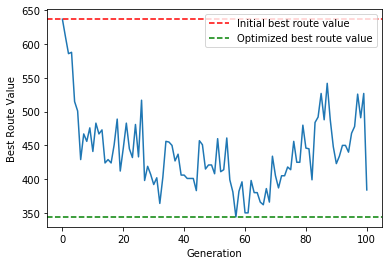

In [121]:
print("MAX_DISTANCE")
MAX_DISTANCE = 100
print(MAX_DISTANCE)

J = random_euclidean_graph(15)
G = random_symmetric_graph(15)
print("\nMatrix")
show(G)

print("\nPopulation")
population = 10
print(population)

print("\nMutation in %")
mutation=0.05
print(mutation)

print("\nAmount of generations created")
generations = 100
print(generations)

print("\nRunning ------------------------\n")
results = geneticAlgorithm(population, G, mutation, generations)


print("\n-----------------------\n")

print("Improvement over Time Graph")
def graph(results):
    bestRoute = results[:]
    bestRoute.sort()
    bestRoute = bestRoute[0]
    genList = []
    for i in range(0,len(results)):
        genList.append(i)
    plt.plot(genList, results)
    line_init = plt.axhline(y=results[0], color='r', linestyle='--')
    line_min = plt.axhline(y=bestRoute, color='g', linestyle='--')
    plt.legend([line_init, line_min], ['Initial best route value', 'Optimized best route value'])
    plt.ylabel('Best Route Value')
    plt.xlabel('Generation')
    plt.show()
    
graph(results)
    

Source:
* https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35
*  https://www.geeksforgeeks.org/traveling-salesman-problem-using-genetic-algorithm/ (in C++)
* http://www.theprojectspot.com/tutorial-post/applying-a-genetic-algorithm-to-the-travelling-salesman-problem/5
* https://www.youtube.com/watch?v=XP8R0yzAbdo